In [6]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
import pylab as pl

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

In [7]:
smote_input_df = pd.read_csv('smote_inputs', names=['SMILES', 'used_for_generation'])
smote_output_df = pd.read_csv('smote_outputs', names=['SMILES'])

In [8]:
print(smote_input_df.columns)
print(smote_output_df.columns)

Index(['SMILES', 'used_for_generation'], dtype='object')
Index(['SMILES'], dtype='object')


# 1. Valid / Invalid

In [11]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [12]:
input_smiles = len(smote_input_df)
input_smiles_0 = len(smote_input_df[smote_input_df.used_for_generation == 0])
input_smiles_1 = len(smote_input_df[smote_input_df.used_for_generation == 1])
output_smiles = len(smote_output_df)
smote_output_df['is_valid'] = smote_output_df.SMILES.apply(sanitize)
smote_output_df['is_valid'] = smote_output_df.is_valid.apply(lambda x: x is not None)

print('SMOTE stats:')
print('input_smiles:', input_smiles)
print('input_smiles_0:', input_smiles_0)
print('input_smiles_1:', input_smiles_1)
print('output_smiles:', output_smiles)
print('valid output_smiles:', np.sum(smote_output_df.is_valid))

Sanitization error: Explicit valence for atom # 23 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 15 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 17 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 6 C, 7, is greater than permitted
Sanitization error: Explicit valence for atom # 2 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 5 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 20 C, 5, is greater than permitted
SMOTE sta

In [13]:
smote_output_df.head()

SMILES  is_valid
0    (CN(1cc1Ccccnc1)C1CCN(CC1)C(=O)c1cccnc1     False
1             C(Cc1ccccn1)Nc1ncccc1CCC1CCCN1      True
2   C00=O)(CO=N)CCCCCC1Cc1c1H]ncc1S(C)(=O)=O     False
3  CN(C)c1cc(C)nc(c1)C1CCN(CC1)C(=O)c1ccncc1      True
4     Fc1cccc(c1)S(=O)(=O)N1CCCC(C1)c1cnccn1      True

In [14]:
valid = np.sum(smote_output_df.is_valid)
total = len(smote_output_df)
invalid = total - valid

print('Amount of valid SMILES:', valid, '(', valid / total * 100, '% )')
print('Amount of invalid SMILES:', invalid, '(', invalid / total * 100, '% )')

Amount of valid SMILES: 57556 ( 60.30216038388198 % )
Amount of invalid SMILES: 37890 ( 39.69783961611802 % )


# 2. Identical to inputs

In [45]:
# First, get valid smiles only
valid_smiles_df = smote_output_df[smote_output_df.is_valid == True].drop(columns=['is_valid'])

In [50]:
# make sure we've done evrything correctly
print(len(valid_smiles_df))
valid_smiles_df.head()

57568


SMILES
1             C(Cc1ccccn1)Nc1ncccc1CCC1CCCN1
3  CN(C)c1cc(C)nc(c1)C1CCN(CC1)C(=O)c1ccncc1
4     Fc1cccc(c1)S(=O)(=O)N1CCCC(C1)c1cnccn1
6             CN1CCC(CC1)c1nc2cc(C)ccc2[nH]1
8                 CN1CCN(Cc2ccccc2)CC1C(N)=O

In [63]:
generated = valid_smiles_df['SMILES'].values.tolist()
inpt = smote_input_df['SMILES'].values.tolist()

duplicates = []
unique = []

for mol in generated:
    if mol in inpt:
        duplicates.append(mol)
    else:
        unique.append(mol)

In [64]:
print('unique novel:', len(unique), 'or', len(unique) / len(generated) * 100, '%')
print('generated:', len(generated), 'duplicates:', len(duplicates), 'or', len(duplicates) / len(generated) * 100, '%')

unique novel: 5848 or 10.158421345191773 %
generated: 57568 duplicates: 51720 or 89.84157865480823 %


# 3. Unique novel chemical matter

In [65]:
novel_df = pd.DataFrame({'SMILES': unique})

In [67]:
print(len(novel_df))
novel_df.head()

5848


SMILES
0                CN1CCN(Cc2ccccc2)CC1C(N)=O
1  CCc1cc(C)nc(n1)N1CCN(CC1)C(=O)c1cnn(C)c1
2        CC(=C)NCCC1CCCN(C1)C(=O)c1ccn(C)n1
3      Cc1cc(nc(n1)C1CCCN1c1ccccn1)C(F)(F)F
4    CN(C)S(=O)(=O)N1CCC(Cc2cccc3ccccc23)C1

# 4. Synthetic Accessibility score
Calculation of synthetic accessibility score as described in:

Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
Peter Ertl and Ansgar Schuffenhauer
Journal of Cheminformatics 1:8 (2009)
http://www.jcheminf.com/content/1/1/8

In [81]:
_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
#     if name == "fpscores":
#         name = op.join(op.dirname(__file__), name)
    _fscores = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in _fscores:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict

In [79]:
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(smiles_string):
    if _fscores is None:
        readFragmentScores()
    
    m = Chem.MolFromSmiles(smiles_string)
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m, 2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore

In [84]:
novel_df['synthetic_accessibility_score'] = novel_df.SMILES.apply(calculateScore)

In [87]:
novel_df.to_csv('novel.csv', index=False, header=False)

In [86]:
novel_df.head()

SMILES  synthetic_accessibility_score
0                CN1CCN(Cc2ccccc2)CC1C(N)=O                       2.380660
1  CCc1cc(C)nc(n1)N1CCN(CC1)C(=O)c1cnn(C)c1                       2.372513
2        CC(=C)NCCC1CCCN(C1)C(=O)c1ccn(C)n1                       3.043363
3      Cc1cc(nc(n1)C1CCCN1c1ccccn1)C(F)(F)F                       3.053458
4    CN(C)S(=O)(=O)N1CCC(Cc2cccc3ccccc23)C1                       2.593400

Text(0, 0.5, 'Number of Compunds')

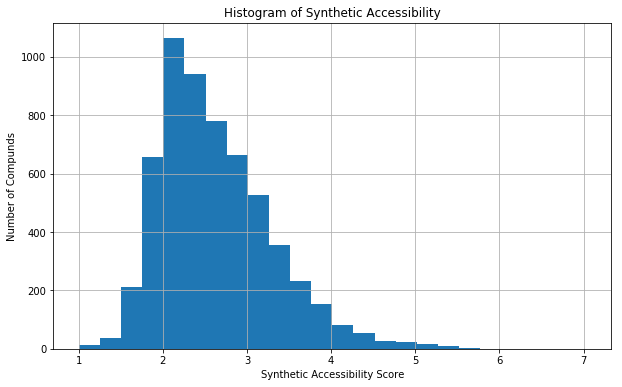

In [105]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)
novel_df.synthetic_accessibility_score.hist(bins=24)
pl.title("Histogram of Synthetic Accessibility")
pl.xlabel("Synthetic Accessibility Score")
pl.ylabel("Number of Compunds")

In [113]:
easy = len(novel_df[novel_df.synthetic_accessibility_score <= 3.5])
total = len(novel_df)
print('easy', easy, 'total', total, 'or', easy / total * 100, '%')

easy 5232 total 5848 or 89.46648426812585 %


# 5. Morgan fingerprints + Tanimoto similarity
Idea: compare molecular fingerprints of SMOTE input 0 class (not used for generation) and generated novel smiles

In [118]:
# extract major and minor classes which were used 
major_class_df = smote_input_df[smote_input_df.used_for_generation == 0]
minor_class_df = smote_input_df[smote_input_df.used_for_generation == 1]

In [143]:
major_class_df.to_pickle('major_class_df.pickle')
minor_class_df.to_pickle('minor_class_df.pickle')
novel_df.to_pickle('novel_df.pickle')

## 5.1 Load data 

In [2]:
major_class_df = pd.read_pickle('backups/major_class_df.pickle')
minor_class_df = pd.read_pickle('backups/minor_class_df.pickle')
novel_df = pd.read_pickle('backups/novel_df.pickle')

In [3]:
print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

285408
189936
5836
Index(['SMILES_major', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['SMILES_minor', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['SMILES_generated', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')


In [4]:
oversampled_class_df = major_class_df.drop(columns=['molecular_weight', 'logP', 'TPSA', 'synthetic_accessibility_score', 'mol'])
undersampled_class_df = minor_class_df.drop(columns=['molecular_weight', 'logP', 'TPSA', 'synthetic_accessibility_score', 'mol'])
novel_df = novel_df.drop(columns=['molecular_weight', 'logP', 'TPSA', 'synthetic_accessibility_score', 'mol'])

In [5]:
print(oversampled_class_df.columns)
print(undersampled_class_df.columns)
print(novel_df.columns)

Index(['SMILES_major'], dtype='object')
Index(['SMILES_minor'], dtype='object')
Index(['SMILES_generated'], dtype='object')


## 5.2 Sanitize

In [9]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [ ]:
novel_df['mol'] = novel_df.SMILES_generated.apply(sanitize)
undersampled_class_df['mol'] = undersampled_class_df.SMILES_minor.apply(sanitize)
oversampled_class_df['mol'] = oversampled_class_df.SMILES_major.apply(sanitize)

In [ ]:
print(len(oversampled_class_df))
print(len(undersampled_class_df))
print(len(novel_df))

oversampled_class_df = oversampled_class_df.dropna()
undersampled_class_df = undersampled_class_df.dropna()
novel_df = novel_df.dropna()

print(len(oversampled_class_df))
print(len(undersampled_class_df))
print(len(novel_df))

In [14]:
oversampled_class_df = oversampled_class_df.drop(columns=['mol'])
undersampled_class_df = undersampled_class_df.drop(columns=['mol'])
novel_df = novel_df.drop(columns=['mol'])

In [15]:
print(oversampled_class_df.columns)
print(undersampled_class_df.columns)
print(novel_df.columns)

Index(['SMILES_major'], dtype='object')
Index(['SMILES_minor', 'key'], dtype='object')
Index(['SMILES_generated', 'key'], dtype='object')


In [16]:
del major_class_df
del minor_class_df

## 5.3 Cartesian product

In [18]:
%%time

from pandas import DataFrame, merge

# add fake column to merge on
undersampled_class_df['key'] = 0
novel_df['key'] = 0

generated_vs_undersampled_cartesian_df = merge(novel_df, undersampled_class_df, on='key')[['SMILES_generated', 'SMILES_minor']]

CPU times: user 3min 19s, sys: 1min 36s, total: 4min 55s
Wall time: 4min 48s


In [8]:
%%time

from pandas import DataFrame, merge

oversampled_class_df['key'] = 0
novel_df['key'] = 0

generated_vs_oversampled_cartesian_df = merge(novel_df, oversampled_class_df, on='key')[['SMILES_generated', 'SMILES_major']]

CPU times: user 4min 39s, sys: 2min 14s, total: 6min 54s
Wall time: 6min 43s


In [9]:
# drop duplicates
generated_vs_oversampled_cartesian_df = generated_vs_oversampled_cartesian_df.drop_duplicates(subset=['SMILES_generated', 'SMILES_major'], keep=False)

In [10]:
print(len(generated_vs_oversampled_cartesian_df))

1541488608


In [11]:
%%time

# remove random 90% values, create subset
remove_n = int(0.9 * len(generated_vs_oversampled_cartesian_df))
drop_indices = np.random.choice(generated_vs_oversampled_cartesian_df.index, remove_n, replace=False)
df_subset_oversampled = generated_vs_oversampled_cartesian_df.drop(drop_indices)

CPU times: user 10min 31s, sys: 35.4 s, total: 11min 7s
Wall time: 11min 7s


In [12]:
len(df_subset_oversampled)

154148861

In [13]:
# store the subset as pickle
df_subset_oversampled.to_pickle('backups/df_subset_oversampled.pickle')

In [3]:
df_subset_oversampled = pd.read_pickle('backups/df_subset_oversampled.pickle')

In [19]:
print(len(generated_vs_undersampled_cartesian_df))
generated_vs_undersampled_cartesian_df.head()

1108466496


SMILES_generated                              SMILES_minor
0  CN1CCN(Cc2ccccc2)CC1C(N)=O       OC(=O)c1n(nc2ccccc12)C1CCCc2ccccc12
1  CN1CCN(Cc2ccccc2)CC1C(N)=O           CC(C)N1CCN(C(C1)C(N)=O)c1ncccn1
2  CN1CCN(Cc2ccccc2)CC1C(N)=O             CC(C)N1CCN(CC1C(N)=O)c1ncccn1
3  CN1CCN(Cc2ccccc2)CC1C(N)=O              CN1CCN(CC1C(N)=O)c1cc(C)ncn1
4  CN1CCN(Cc2ccccc2)CC1C(N)=O  CN(C)C(=O)C1CN(CCN1C(=O)Cc1ccccc1)C(C)=O

In [20]:
# drop duplicates
generated_vs_undersampled_cartesian_df = generated_vs_undersampled_cartesian_df.drop_duplicates(subset=['SMILES_generated', 'SMILES_minor'], keep=False)

In [21]:
print(len(generated_vs_undersampled_cartesian_df))

1025844336


In [22]:
df_list = np.array_split(generated_vs_undersampled_cartesian_df, 11)

In [23]:
%%time

i = 0

for df in df_list:
    i += 1
    df.to_pickle('backups/generated_vs_undersampled_cartesian_df_{}.pickle'.format(i))

CPU times: user 2min 37s, sys: 34.4 s, total: 3min 11s
Wall time: 4min 13s


In [26]:
%%time

# remove random 90% values, create subset
remove_n = int(0.9 * len(generated_vs_undersampled_cartesian_df))
drop_indices = np.random.choice(generated_vs_undersampled_cartesian_df.index, remove_n, replace=False)
df_subset = generated_vs_undersampled_cartesian_df.drop(drop_indices)

CPU times: user 7min 55s, sys: 28.9 s, total: 8min 24s
Wall time: 8min 24s


In [27]:
len(df_subset)

102584434

In [28]:
# store the subset as pickle
df_subset.to_pickle('backups/df_subset.pickle')

In [29]:
df_subset.head()

SMILES_generated  \
21  CN1CCN(Cc2ccccc2)CC1C(N)=O   
32  CN1CCN(Cc2ccccc2)CC1C(N)=O   
44  CN1CCN(Cc2ccccc2)CC1C(N)=O   
52  CN1CCN(Cc2ccccc2)CC1C(N)=O   
59  CN1CCN(Cc2ccccc2)CC1C(N)=O   

                                         SMILES_minor  
21  CCc1nc2cccnc2n1C1CCN(C1)C(=O)c1cc2c(OC)c(OC)cc...  
32                          CN1CCNCC1c1cccc(c1)C(O)=O  
44                 CC(C)N1CCC(CC1)c1nc(ncc1NCCO)N(C)C  
52          Cc1cc(CCC(N)=O)nc(n1)C1CCCN(C1)S(C)(=O)=O  
59                  O=C(NCc1ccccc1)C1CCCN(C1)c1cccnn1

## Load data

In [3]:
import os

data_folder = 'backups'
prefix = 'generated_vs_undersampled_cartesian_df'
filenames = os.listdir(data_folder)
df_list = []

for filename in filenames:
    if filename.startswith(prefix):
        df_list.append(pd.read_pickle(os.path.join(data_folder, filename)))

## 5.4 Compute Morgan Fingerprints and Tanimoto similarity

In [4]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def get_tanimoto_similarity_from_smiles(a_row):
    smiles_string_a = a_row[0]
    smiles_string_b = a_row[1]
    mol_a = Chem.MolFromSmiles(smiles_string_a)
    mol_b = Chem.MolFromSmiles(smiles_string_b)
    
    if mol_a and mol_b:
        morgan_fp_a = AllChem.GetMorganFingerprintAsBitVect(mol_a, 2)  # radius = 2
        morgan_fp_b = AllChem.GetMorganFingerprintAsBitVect(mol_b, 2)  # radius = 2
        
        return DataStructs.TanimotoSimilarity(morgan_fp_a, morgan_fp_b)

In [5]:
# compute on a subset
df_subset_oversampled['tanimoto_similarity'] = df_subset_oversampled.apply(get_tanimoto_similarity_from_smiles, axis=1)
df_subset_oversampled.to_pickle('backups/df_subset_oversampled.pickle')

In [ ]:
# compute on a subset
df_subset['tanimoto_similarity'] = df_subset.apply(get_tanimoto_similarity_from_smiles, axis=1)
df_subset.to_pickle('backups/df_subset.pickle')

In [15]:
df_subset = pd.read_pickle('backups/df_subset.pickle')

In [16]:
df_subset.head()

SMILES_generated  \
21  CN1CCN(Cc2ccccc2)CC1C(N)=O   
32  CN1CCN(Cc2ccccc2)CC1C(N)=O   
44  CN1CCN(Cc2ccccc2)CC1C(N)=O   
52  CN1CCN(Cc2ccccc2)CC1C(N)=O   
59  CN1CCN(Cc2ccccc2)CC1C(N)=O   

                                         SMILES_minor  tanimoto_similarity  
21  CCc1nc2cccnc2n1C1CCN(C1)C(=O)c1cc2c(OC)c(OC)cc...             0.164706  
32                          CN1CCNCC1c1cccc(c1)C(O)=O             0.263158  
44                 CC(C)N1CCC(CC1)c1nc(ncc1NCCO)N(C)C             0.126761  
52          Cc1cc(CCC(N)=O)nc(n1)C1CCCN(C1)S(C)(=O)=O             0.202899  
59                  O=C(NCc1ccccc1)C1CCCN(C1)c1cccnn1             0.265625

Text(0, 0.5, 'Probability density')

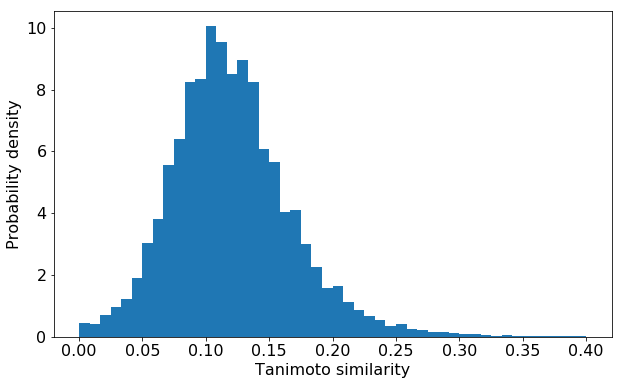

In [17]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
df_subset.tanimoto_similarity.hist(
    bins=48,
    range=[0, 0.4],
    align='mid',
    density=True,
    grid=False)
pl.xlabel("Tanimoto similarity")
pl.ylabel("Probability density")

In [ ]:
%%time

import multiprocessing
from tqdm import tqdm
import dask.dataframe as dd

# similarities = pd.DataFrame(columns=['tanimoto_similarity'])

for df in tqdm(df_list):
    print('Current dataframe length:', len(df))
#     dmaster = dd.from_pandas(df, npartitions=multiprocessing.cpu_count())
#     dmaster['tanimoto_similarity'] = dmaster.apply(get_tanimoto_similarity_from_smiles, axis=1)
#     results_series = dmaster.compute(scheduler='processes')['tanimoto_similarity']
#     similarities = similarities.append(results_series, ignore_index=True)
    df['tanimoto_similarity'] = df.apply(get_tanimoto_similarity_from_smiles, axis=1)



  0%|          | 0/11 [00:00<?, ?it/s]

Current dataframe length: 100769681




  9%|▉         | 1/11 [18:28:15<184:42:38, 66495.86s/it]

Current dataframe length: 100769681


In [ ]:
%%time

i = 0

for df in df_list:
    i += 1
    df.to_pickle('backups/generated_vs_undersampled_cartesian_df_{}.pickle'.format(i))

In [ ]:
generated_vs_minor_cartesian_df.head()

In [ ]:
ax = generated_vs_minor_cartesian_df.hist(column='Tanimoto_similarity',
#                                           by='user_type',
                                          bins=10,
                                          grid=False,
                                          figsize=(8,10),
                                          layout=(3,1),
                                          sharex=True,
                                          color='#86bf91',
                                          zorder=2,
                                          rwidth=0.9)

In [ ]:
for i,x in enumerate(ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("Session Duration (Seconds)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("Sessions", labelpad=50, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=0)

In [ ]:
generated_vs_minor_cartesian_df.to_pickle('generated_vs_minor_cartesian_df.pickle')

In [ ]:
major_class_df['key'] = 0

generated_vs_major_cartesian_df = merge(novel_df, major_class_df, on='key')[['SMILES_generated', 'SMILES_major']]

In [ ]:
generated_vs_major_cartesian_df.to_pickle('generated_vs_major_cartesian_df.pickle')

In [142]:
from tqdm import tqdm

generated_vs_minor_cartesian_df = pd.DataFrame(columns=['SMILES_generated', 'SMILES_minor', 'Tanimoto_similarity'])
rows = len(novel_df)

i = 0
for row_a in tqdm(range(rows)):
    smiles_a = novel_df.loc[row_a]['SMILES']
    
    for _, row_b in minor_class_df.iterrows():
        smiles_b = row_b['SMILES']
        similarity = get_tanimoto_similarity_from_smiles(smiles_a, smiles_b)
        
        if similarity:
            generated_vs_minor_cartesian_df.loc[i] = [smiles_a, smiles_b, similarity]
            i += 1


  0%|          | 4/5848 [9:43:53<13926:03:22, 8578.68s/it]

KeyboardInterrupt: 

In [ ]:
# store as pickle
generated_vs_minor_cartesian_df.to_pickle('generated_vs_minor_cartesian_df.pickle')

In [127]:
%%time

major_class_df['molecular_fingerprint'] = major_class_df.SMILES.apply(generate_morgan_fingerprint_from_smiles)
minor_class_df['molecular_fingerprint'] = minor_class_df.SMILES.apply(generate_morgan_fingerprint_from_smiles)
novel_df['molecular_fingerprint'] = novel_df.SMILES.apply(generate_morgan_fingerprint_from_smiles)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 2min 26s, sys: 104 ms, total: 2min 26s
Wall time: 2min 26s


In [132]:
import itertools

def cartesian(df1, df2):
    rows = itertools.product(df1.iterrows(), df2.iterrows())

    df = pd.DataFrame(left.append(right) for (_, left), (_, right) in rows)
    return df.reset_index(drop=True)

In [135]:
# make cartesian products of minor class & generated and major class & generated
generated_vs_minor_cartesian = cartesian(pd.DataFrame({'SMILES generated':novel_df.SMILES.values}),
                                         pd.DataFrame({'SMILES minor':minor_class_df.SMILES.values}))
generated_vs_major_cartesian = cartesian(pd.DataFrame({'SMILES generated':novel_df.SMILES.values}),
                                         pd.DataFrame({'SMILES major':major_class_df.SMILES.values}))

KeyboardInterrupt: 

In [ ]:
# check lenghts
print('len(generated_vs_minor_cartesian)', len(generated_vs_minor_cartesian))
print('len(generated_vs_major_cartesian)', len(generated_vs_major_cartesian))

# store as pickles as computations are too time consuming
generated_vs_minor_cartesian.to_pickle('generated_vs_minor_cartesian_df.pickle')
generated_vs_major_cartesian.to_pickle('generated_vs_major_cartesian_df.pickle')

In [ ]:
from rdkit import DataStructs

generated_vs_minor_cartesian['tanimoto_similarity'] = 
generated_vs_major_cartesian['tanimoto_similarity'] = 